In [12]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json

# Nome do bairro, cidade e país
place_name = "L'Esquerra de l'Eixample, Barcelona, Spain"

# Obter o grafo apenas para o bairro desejado
G = ox.graph_from_place(place_name, network_type="drive")

In [13]:
# Função para determinar a região de um nó com base em coordenadas
def determinar_regiao(x, y, centro, matriz_rotacao):
    novo_x, novo_y = np.dot(matriz_rotacao, [x - centro[0], y - centro[1]])
    if novo_x >= 0 and novo_y > 0:
        return "nordeste"
    elif novo_x < 0 and novo_y > 0:
        return "noroeste"
    elif novo_x >= 0 and novo_y <= 0:
        return "sudeste"
    elif novo_x < 0 and novo_y <= 0:
        return "sudoeste"

dict_regiao = {"nordeste": 0,
               "noroeste": 1,
               "sudeste": 2,
               "sudoeste": 3}
# Coordenadas do centro e ângulo para a matriz de rotação
centro = (2.1573688, 41.3881816)
theta = -np.pi / 3  # Ajuste o ângulo para dividir as regiões
matriz_rotacao = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)],
])

# Mapear os nós para índices numéricos consecutivos
node_to_index = {node: idx for idx, node in enumerate(G.nodes)}
# Ajustar classificação de segmentos para evitar regiões de transição
segmentos = []
id_counter = 0
arestas_adicionadas = set()


for u, v, data in G.edges(data=True):
    x0, y0 = G.nodes[u]["x"], G.nodes[u]["y"]
    x1, y1 = G.nodes[v]["x"], G.nodes[v]["y"]


    # Determinar região do nó de saída
    regiao = determinar_regiao(x0, y0, centro, matriz_rotacao)

    # Adicionar segmento de ida (usando apenas a região do nó de saída)
    if (node_to_index[u], node_to_index[v]) not in arestas_adicionadas:
        nome_rua = data.get('name', f'Rua desconhecida {id_counter}')
        if isinstance(nome_rua, list):
            nome_rua = nome_rua[0]
        segmento_ida = {
            "id": id_counter,
            "vSaida": node_to_index[u],
            "vEntrada": node_to_index[v],
            "limVel": data.get("maxspeed", "N/A"),
            "tamanho": int(data.get("length", 0)),
            "rua": f"{nome_rua}_{regiao}",
            "regiao": regiao,
            "CEP": dict_regiao[regiao],
            "volta": False,
            "imoveis": []
        }
        id_counter += 1
        segmentos.append(segmento_ida)
        arestas_adicionadas.add((node_to_index[u], node_to_index[v]))

    # Adicionar segmento de volta, se a rua não for mão única
    if not data.get("oneway", False) and (node_to_index[v], node_to_index[u]) not in arestas_adicionadas:
        regiao_volta = determinar_regiao(x1, y1, centro, matriz_rotacao)  # Região do nó de entrada
        segmento_volta = {
            "id": id_counter,
            "vSaida": node_to_index[v],
            "vEntrada": node_to_index[u],
            "limVel": data.get("maxspeed", "N/A"),
            "tamanho": int(data.get("length", 0)),
            "rua": f"{data.get('name', f'Rua desconhecida {id_counter}')}_{regiao_volta}",
            "regiao": regiao_volta,
            "volta": True,
            "imoveis": []
        }
        id_counter += 1
        segmentos.append(segmento_volta)
        arestas_adicionadas.add((node_to_index[v], node_to_index[u]))


# Criar lista de adjacência
num_vertices = len(node_to_index)
listaAdj = [[] for _ in range(num_vertices)]
for segmento in segmentos:
    listaAdj[segmento["vSaida"]].append(segmento)

print(listaAdj)


[[{'id': 0, 'vSaida': 0, 'vEntrada': 1, 'limVel': '50', 'tamanho': 132, 'rua': 'Gran Via de les Corts Catalanes_sudoeste', 'regiao': 'sudoeste', 'CEP': 3, 'volta': False, 'imoveis': []}, {'id': 1, 'vSaida': 0, 'vEntrada': 34, 'limVel': '50', 'tamanho': 150, 'rua': 'Carrer de Casanova_sudoeste', 'regiao': 'sudoeste', 'CEP': 3, 'volta': False, 'imoveis': []}], [{'id': 2, 'vSaida': 1, 'vEntrada': 75, 'limVel': '50', 'tamanho': 19, 'rua': 'Carrer de Muntaner_sudoeste', 'regiao': 'sudoeste', 'CEP': 3, 'volta': False, 'imoveis': []}, {'id': 3, 'vSaida': 1, 'vEntrada': 105, 'limVel': '50', 'tamanho': 134, 'rua': 'Gran Via de les Corts Catalanes_sudoeste', 'regiao': 'sudoeste', 'CEP': 3, 'volta': False, 'imoveis': []}], [{'id': 4, 'vSaida': 2, 'vEntrada': 3, 'limVel': '50', 'tamanho': 137, 'rua': 'Carrer de París_noroeste', 'regiao': 'noroeste', 'CEP': 1, 'volta': False, 'imoveis': []}, {'id': 5, 'vSaida': 2, 'vEntrada': 49, 'limVel': '50', 'tamanho': 130, 'rua': 'Carrer de Villarroel_noroeste

In [14]:
# Colete todos os nomes de ruas únicos
nomes = set()

for segmento in segmentos:
    nome_rua = segmento["rua"]
    if isinstance(nome_rua, list):
        nome_rua = nome_rua[0]  # Converte a lista em uma string concatenada
        segmento["rua"] = nome_rua
    nomes.add(nome_rua)

# Conte a quantidade de nomes únicos
quantidade_ruas_diferentes = len(nomes)

# Exiba o resultado
quantidade_ruas_diferentes


60

In [15]:
import random
from collections import defaultdict

# Função para encontrar chains de ruas por IDs de ruas
def encontrar_chains(segmentos):
    # Agrupar segmentos por ID de rua (e não mais por nome de rua sem região)
    ruas_dict = defaultdict(list)

    for segmento in segmentos:
        nome = segmento["rua"].split("_")[0]
        ruas_dict[nome].append(segmento)
    print( sum(len(ruas_dict[rua]) for rua in ruas_dict))
    chains = {}
    for id_rua, segmentos_da_rua in ruas_dict.items():
        # Criar grafo de segmentos conectados
        grafo_rua = defaultdict(set)
        for segmento in segmentos_da_rua:
            grafo_rua[segmento["vSaida"]].add(segmento["vEntrada"])
            grafo_rua[segmento["vEntrada"]].add(segmento["vSaida"])

        # Encontrar componentes conectados
        visitados = set()
        componentes = []

        def dfs(no, componente):
            visitados.add(no)
            componente.append(no)
            for vizinho in grafo_rua[no]:
                if vizinho not in visitados:
                    dfs(vizinho, componente)

        for no in grafo_rua:
            if no not in visitados:
                componente = []
                dfs(no, componente)
                componentes.append(componente)

        # Associar a chain com o ID da rua
        chains[id_rua] = componentes

    return chains

# Função para gerar imóveis para cada segmento dentro de cada chain
def gerar_imoveis_por_chain(chains, segmentos):
    voltas = set()  # Set para armazenar os segmentos de volta
    ruas_com_imoveis = {}  # Dicionário para armazenar imóveis por rua (segmento de ida)

    # Primeiro, processar todos os segmentos de ida
    for rua, componentes in chains.items():
        for componente in componentes:
            distancia_acumulada = 0  # Inicializa a distância acumulada para a chain
            for segmento_id in componente:
                segmento = next(s for s in segmentos if s["id"] == segmento_id)

                # Verificar se o segmento é de ida
                if not segmento["volta"]:
                    num_imoveis = random.randint(3, 5)
                    imoveis = []

                    # Gerar imóveis com dFinalSeg crescente
                    for i in range(num_imoveis):
                        dFinalSeg = random.randint(1, segmento["tamanho"]) if segmento["tamanho"] > 0 else 0
                        tipo = random.choice(["residencial", "comercial", "industrial", "atração turística"])
                        imovel = {
                            "dFinalSeg": dFinalSeg,  # Distância final no segmento
                            "num": dFinalSeg + distancia_acumulada,  # Número do imóvel (acumulado com a distância)
                            "tipo": tipo
                        }
                        imoveis.append(imovel)

                    # Ordenar imóveis pela distância
                    imoveis.sort(key=lambda x: x["dFinalSeg"])

                    # Salvar os imóveis associados ao nome da rua (sem região para evitar duplicação de direções)
                    nome_rua_base = segmento["rua"].split("_")[0]
                    ruas_com_imoveis[nome_rua_base] = imoveis

                    # Adicionar imóveis ao segmento
                    segmento["imoveis"] = imoveis
                    distancia_acumulada += segmento["tamanho"]  # Atualiza a distância acumulada

                else:
                    voltas.add(segmento["id"])  # Adicionar segmento de volta ao conjunto de voltas

    # Processar segmentos de volta
    for segmento_id in voltas:
        print("ok")
        segmento = next(s for s in segmentos if s["id"] == segmento_id)
        segmento_id_ida = segmento["id_ida"]  # Referência para o segmento de ida

        # Encontrar o segmento de ida correspondente
        segmento_ida = next(s for s in segmentos if s["id"] == segmento_id_ida)

        # Copiar imóveis do segmento de ida e ajustar a distância para a volta
        if "imoveis" in segmento_ida:
            imoveis_volta = []
            for imovel in segmento_ida["imoveis"]:
                # Ajustar a distância final para refletir a volta (invertendo a direção)
                imovel_volta = imovel.copy()
                imovel_volta["dFinalSeg"] = segmento["tamanho"] - imovel["dFinalSeg"]
                imovel_volta["num"] = imovel_volta["dFinalSeg"] + distancia_acumulada
                imoveis_volta.append(imovel_volta)

            # Ordenar imóveis de volta pela nova distância
            imoveis_volta.sort(key=lambda x: x["dFinalSeg"])

            # Adicionar imóveis ao segmento de volta
            segmento["imoveis"] = imoveis_volta

    return segmentos


# Usando list comprehension para achatar a lista de listas em uma lista única de dicionários
lista_unica = [item for sublist in listaAdj for item in sublist]

# Encontrar chains de ruas
chains = encontrar_chains(lista_unica)

# Exibir resultado das chains
print(f"Chains por rua: {len(chains)}")
for rua, componentes in chains.items():
    print(f"Rua: {rua}")
    for componente in componentes:
        print(f"  Chain: {componente}")

# Gerar imóveis para cada segmento
gerar_imoveis_por_chain(chains, lista_unica)

# Exibir exemplo de segmentos com imóveis
print("\nExemplo de segmentos com imóveis:")
for segmento in segmentos[:5]:  # Mostrar os primeiros 5 segmentos
    print(f"Segmento ID: {segmento['id']}, Rua: {segmento['rua']}, Imóveis: {segmento['imoveis']}")


221
Chains por rua: 36
Rua: Gran Via de les Corts Catalanes
  Chain: [0, 1, 105, 64, 117, 61]
Rua: Carrer de Casanova
  Chain: [0, 34, 124, 125, 65, 33, 32, 31, 30, 29, 3, 10, 86, 28, 68, 84, 118, 102, 70]
Rua: Carrer de Muntaner
  Chain: [1, 27, 123, 122, 26, 25, 24, 23, 22, 21, 4, 11, 85, 72, 82, 75]
Rua: Carrer de París
  Chain: [2, 3, 4, 5, 6, 7, 109, 59]
Rua: Carrer de Villarroel
  Chain: [2, 49, 35, 43, 40, 50, 94, 118, 119, 39, 117, 51, 9, 48, 71]
Rua: Carrer d'Aribau
  Chain: [5, 12, 13, 87, 14, 15, 16, 17, 18, 19, 127, 126, 20, 105]
Rua: Carrer d'Enric Granados
  Chain: [6, 52, 53, 36, 44, 41, 73]
  Chain: [128, 74]
Rua: Carrer de Balmes
  Chain: [7, 54, 83, 55, 56, 37, 45, 42, 57, 106, 121, 112, 64, 79]
Rua: Avinguda de Sarrià
  Chain: [8, 108, 59, 47, 81, 90, 69]
Rua: Carrer de Londres
  Chain: [9, 10, 11, 12, 63, 8]
Rua: Avinguda Diagonal (lateral mar)
  Chain: [13, 72, 68, 71, 89, 97, 54]
Rua: Carrer de Còrsega
  Chain: [14, 52, 55, 21, 29, 49, 99]
Rua: Carrer del Rosselló

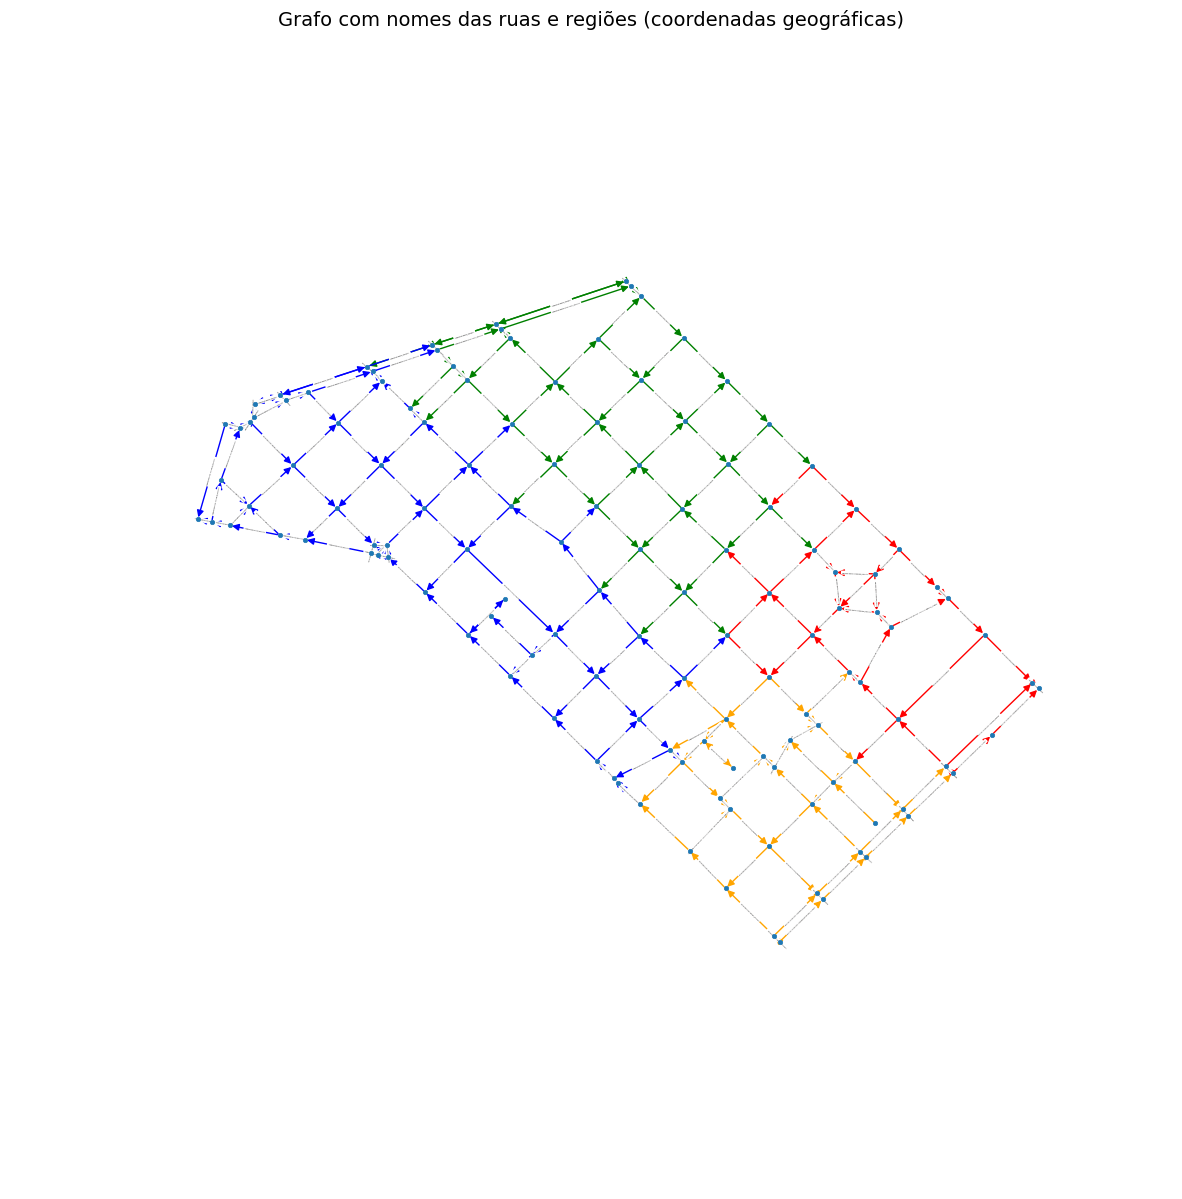

In [16]:
import matplotlib.pyplot as plt
import networkx as nx

# Define as cores das regiões
cores_regioes = {
    "noroeste": "blue",
    "nordeste": "green",
    "sudeste": "red",
    "sudoeste": "orange",
}

# Adicionar a região aos dados das arestas
for u, v, data in G.edges(data=True):
    x0, y0 = G.nodes[u]["x"], G.nodes[u]["y"]
    regiao = determinar_regiao(x0, y0, centro, matriz_rotacao)  # Determina a região do nó de saída
    data["regiao"] = regiao  # Adiciona a região ao atributo da aresta

# Obter as posições dos nós
pos = {node: (data["x"], data["y"]) for node, data in G.nodes(data=True)}

# Obter as cores das arestas com base na região
edge_colors = [cores_regioes[data["regiao"]] for _, _, data in G.edges(data=True)]

# Obter os rótulos das arestas com base nas ruas
edge_labels = {
    (u, v): f'{data.get("name", "Rua desconhecida")}_{data["regiao"]}'
    for u, v, data in G.edges(data=True)
}

# Desenhar o grafo
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw(
    G,
    pos,
    ax=ax,
    node_size=10,
    edge_color=edge_colors,  # Arestas coloridas por região
    linewidths=0.5,
    with_labels=False,
)

# Adicionar os rótulos das arestas
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=0, label_pos=0.5)

plt.title("Grafo com nomes das ruas e regiões (coordenadas geográficas)", fontsize=14)
plt.show()


In [11]:
import plotly.graph_objects as go

# Criar dicionário para mapear arestas no grafo às informações de planta_data
aresta_to_id = {}

for v_saida, segmentos in enumerate(planta_data["listaAdj"]):
    for segmento in segmentos:
        aresta_to_id[(segmento["vSaida"], segmento["vEntrada"])] = segmento["id"]
# Obter posições reais dos nós no grafo (latitude e longitude)
pos = {node: (data["x"], data["y"]) for node, data in G.nodes(data=True)}

# Mapear os nós para índices numéricos consecutivos
node_labels = {node: str(idx) for idx, node in enumerate(G.nodes)}

# Criar listas para as coordenadas das arestas e seus rótulos
edge_x = []
edge_y = []
edge_labels = []

for u, v, data in G.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x.extend([x0, x1, None])  # None para quebrar a linha entre arestas
    edge_y.extend([y0, y1, None])
    segment_id = aresta_to_id.get((int(node_labels[u]), int(node_labels[v])), "N/A")  # Pegar o ID do segmento
    # rua = data.get("name", "Rua desconhecida")
    edge_labels.append(((x0 + x1) / 2, (y0 + y1) / 2, f"{segment_id}"))

# Criar trace para as arestas
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Criar listas para as coordenadas dos nós
node_x = []
node_y = []
node_text = []
for node, (x, y) in pos.items():
    node_x.append(x)
    node_y.append(y)
    node_text.append(node_labels[node])  # Usar os rótulos personalizados

# Criar trace para os nós
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=node_text,
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(
            thickness=15,
            title='Nó ID',
            xanchor='left',
            titleside='right'
        ),
    )
)

# Criar trace para os rótulos das arestas
edge_label_trace = go.Scatter(
    x=[label[0] for label in edge_labels],
    y=[label[1] for label in edge_labels],
    mode='text',
    text=[label[2] for label in edge_labels],
    textfont=dict(size=8, color='blue'),
    hoverinfo='none'
)

# Configurar o layout do grafo
fig = go.Figure(data=[edge_trace, node_trace, edge_label_trace],
                layout=go.Layout(
                    title='<br>Grafo com IDs e nomes das ruas',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                ))

# Mostrar o grafo interativo
fig.show()


NameError: name 'planta_data' is not defined

In [17]:
# 3. Salve no formato JSON
with open("mapa.json", "w", encoding="utf-8") as f:
    json.dump(listaAdj, f, ensure_ascii=False, indent=4)

In [ ]:
# Criando os imóveis

